In [1]:
import outlines
import io
from datasets import load_dataset
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

C:\Users\zelaw\PycharmProjects\Kaggle_Gym\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset with Hugging Face
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

Original Image:


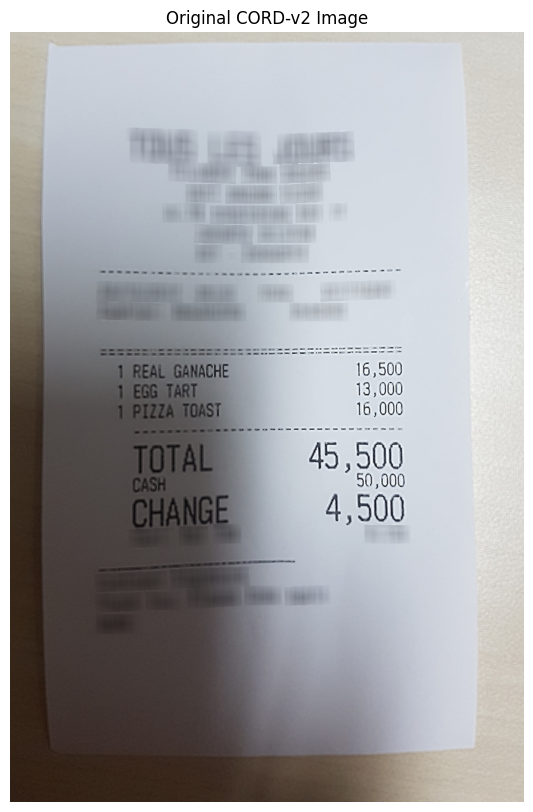


Ground Truth JSON (partial):
{
  "menu": [
    {
      "nm": "REAL GANACHE",
      "cnt": "1",
      "price": "16,500"
    },
    {
      "nm": "EGG TART",
      "cnt": "1",
      "price": "13,000"
    },
    {
      "nm": "PIZZA TOAST",
      "cnt": "1",
      "price": "16,000"
    }
  ],
  "total": {
    "total_price": "45,500",
    "cashprice": "50,000",
    "changeprice": "4,500"
  }
}...


In [3]:
sample_image_data = dataset[0] # Take the first example
sample_image_pil = sample_image_data["image"].convert("RGB") # Ensure it's RGB
ground_truth_json_str = sample_image_data["ground_truth"]
ground_truth_dict = json.loads(ground_truth_json_str)

print("Original Image:")
plt.figure(figsize=(8, 10))
plt.imshow(sample_image_pil)
plt.axis('off')
plt.title("Original CORD-v2 Image")
plt.show()

print("\nGround Truth JSON (partial):")
# Pretty print a part of the ground truth for understanding
print(json.dumps(ground_truth_dict["gt_parse"], indent=2)[:500] + "...") # Show first 500 chars


PyTesseract OCR Results (first 10 words):
Text: '16,500', BBox: [584, 530, 659, 582], Confidence: 86
Text: '13,000', BBox: [583, 589, 659, 615], Confidence: 89
Text: '16,000', BBox: [583, 622, 660, 648], Confidence: 88
Text: '45', BBox: [503, 690, 543, 735], Confidence: 89
Text: ',900', BBox: [563, 690, 660, 742], Confidence: 79
Text: '50,000', BBox: [584, 742, 663, 769], Confidence: 86
Text: '4,500', BBox: [531, 777, 663, 830], Confidence: 93


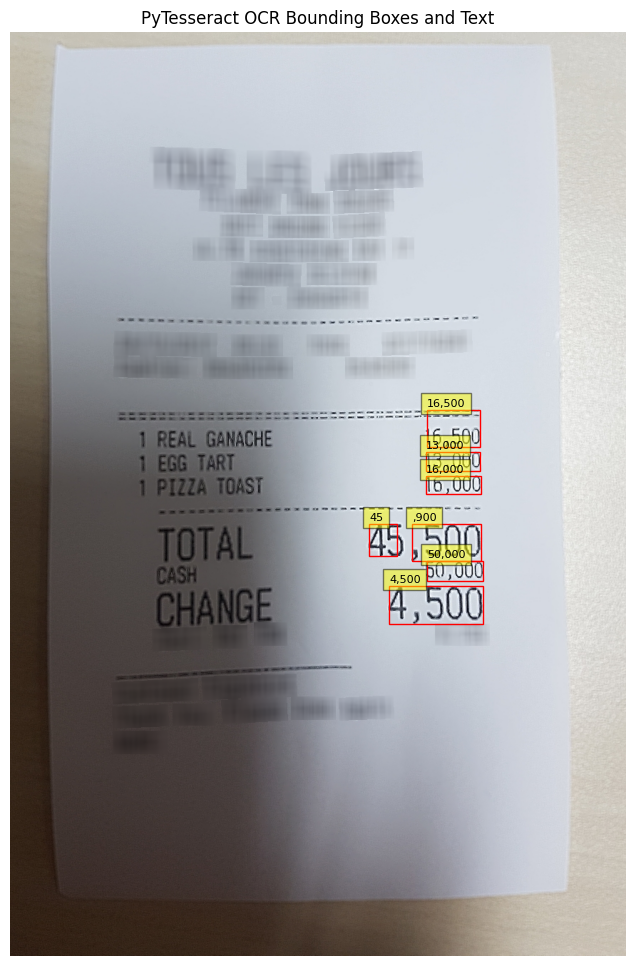

In [4]:
import pytesseract
from pytesseract import Output
import cv2
import numpy as np

# If tesseract is not in your PATH, uncomment and set the path
# pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract' # Adjust path for your system

# Convert PIL Image to OpenCV format (NumPy array)
image_cv = np.array(sample_image_pil)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR) # OpenCV expects BGR

# Get bounding box data
# output_type=Output.DICT gives a dictionary with text, bounding boxes, confidence, etc.
# 'level' 5 typically corresponds to words.
data = pytesseract.image_to_data(image_cv, output_type=Output.DICT, lang='eng')

ocr_tokens_tesseract = []
ocr_bboxes_tesseract = []
ocr_confidences_tesseract = []

n_boxes = len(data['text'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 70: # Only take confident detections
        text = data['text'][i].strip()
        if text: # Ensure text is not empty
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            ocr_tokens_tesseract.append(text)
            ocr_bboxes_tesseract.append([x, y, x + w, y + h]) # Format [x_left, y_top, x_right, y_bottom]
            ocr_confidences_tesseract.append(int(data['conf'][i]))

print(f"\nPyTesseract OCR Results (first 10 words):")
for i in range(min(10, len(ocr_tokens_tesseract))):
    print(f"Text: '{ocr_tokens_tesseract[i]}', BBox: {ocr_bboxes_tesseract[i]}, Confidence: {ocr_confidences_tesseract[i]}")

# Visualize PyTesseract results
plt.figure(figsize=(10, 12))
ax = plt.gca()
ax.imshow(sample_image_pil)
for i in range(len(ocr_tokens_tesseract)):
    x1, y1, x2, y2 = ocr_bboxes_tesseract[i]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, ocr_tokens_tesseract[i], bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8, color='black')
plt.axis('off')
plt.title("PyTesseract OCR Bounding Boxes and Text")
plt.show()

In [6]:
from paddleocr import PaddleOCR

# Initialize PaddleOCR (this downloads models the first time)
# use_angle_cls=True helps with rotated text
# lang='en' specifies English model
ocr_paddle = PaddleOCR(use_angle_cls=True, lang='en')

# Perform OCR
# PaddleOCR expects a file path or numpy array
# Convert PIL Image to NumPy array (RGB) for PaddleOCR
image_np_rgb = np.array(sample_image_pil)
result_paddle = ocr_paddle.ocr(image_np_rgb)

ocr_tokens_paddle = []
ocr_bboxes_paddle = []
ocr_confidences_paddle = []

# PaddleOCR result structure: result[0] contains a list of detected lines/words
# Each item in the list is [bbox, (text, confidence)]
# BBox format is [[x1, y1], [x2, y2], [x3, y3], [x4, y4]] (4 points for rotated rect)
# We need to convert it to [x_left, y_top, x_right, y_bottom]
if result_paddle and result_paddle[0]: # Check if any results are found
    for line in result_paddle[0]:
        bbox_coords = line[0] # List of 4 [x,y] points
        text, confidence = line[1]

        # Convert 4-point bounding box to 2-point (min/max)
        x_coords = [p[0] for p in bbox_coords]
        y_coords = [p[1] for p in bbox_coords]
        x1, y1 = int(min(x_coords)), int(min(y_coords))
        x2, y2 = int(max(x_coords)), int(max(y_coords))

        ocr_tokens_paddle.append(text)
        ocr_bboxes_paddle.append([x1, y1, x2, y2])
        ocr_confidences_paddle.append(confidence)

print(f"\nPaddleOCR OCR Results (first 10 words):")
for i in range(min(10, len(ocr_tokens_paddle))):
    print(f"Text: '{ocr_tokens_paddle[i]}', BBox: {ocr_bboxes_paddle[i]}, Confidence: {ocr_confidences_paddle[i]:.2f}")

# Visualize PaddleOCR results
plt.figure(figsize=(10, 12))
ax = plt.gca()
ax.imshow(sample_image_pil)
for i in range(len(ocr_tokens_paddle)):
    x1, y1, x2, y2 = ocr_bboxes_paddle[i]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, ocr_tokens_paddle[i], bbox=dict(facecolor='cyan', alpha=0.5), fontsize=8, color='black')
plt.axis('off')
plt.title("PaddleOCR Bounding Boxes and Text")
plt.show()

C:\Users\zelaw\AppData\Local\Temp\ipykernel_19724\1482003011.py:6: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_paddle = PaddleOCR(use_angle_cls=True, lang='en')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\zelaw\.paddlex\official_models.
Fetching 6 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1431.75it/s]
Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!


ValueError: not enough values to unpack (expected 2, got 1)